Here I test if conv nets can be used to detect patterns in movements.

For that I train CNN on the data, where each channel represents a feature, one row represents and observation and number of columns in that row coressponds to the number of timesteps.

In [44]:
import os
import sys

import numpy as np
import numpy.ma as ma
np.random.seed(42)

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Reload modules after they were changed 
%load_ext autoreload
%autoreload 2

from plot_helpers import plot_confusion_matrix, plot_path
from helpers import traject_to_coord
from data_preprocessing import denorm, norm_values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:

# Load the data
x_data = np.load('data/x_data.npy')
y_data = np.load('data/y_data.npy')

# Fit the label encoder to our label series
encoder = LabelBinarizer()
y_data_hot = encoder.fit_transform(y_data)

# shuffle the data (because of seed it will be shuffled in the same order)
np.random.shuffle(x_data)
np.random.shuffle(y_data_hot)

# expand dimensions in X data to make it: [N obs, 1 (rows), N timesteps (columns), N features (channels)]
x_data = np.expand_dims(x_data, 1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_hot, test_size=0.1, random_state=42)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print()

# compute class probability and set higher weight to rare classes to deal with unbalanced data
sample_weights = compute_sample_weight('balanced', y_train)
print("Classes weights and # of observations:")
for i in zip(*np.unique(sample_weights, return_counts=True)):
    print("\tobs. {},\b weigth: {:.2f}".format(i[1], i[0]))
print()
    
NUM_CLASSES = len(np.unique(y_data, axis=0))
TIMESTEPS = x_data.shape[2]
print("Number of classes:", NUM_CLASSES)
print("Timesteps per observation:", TIMESTEPS)

x_train shape: (37944, 1, 30, 2)
y_train shape: (37944, 6)

37944 train samples
4216 test samples

Classes weights and # of observations:
	obs. 10067, weigth: 0.13
	obs. 9013, weigth: 0.15
	obs. 7276, weigth: 0.20
	obs. 6572, weigth: 0.23
	obs. 2903, weigth: 0.58
	obs. 2113, weigth: 0.81

Number of classes: 6
Timesteps per observation: 30


In [4]:
# input dimensions
input_shape = x_data.shape[1:]

model = Sequential()
model.add(Conv2D(32, kernel_size=(1, 3),
                 activation='relu',
                 input_shape=input_shape, 
                 padding='same',
                 name='conv1', 
                 strides=1))
model.add(MaxPooling2D(pool_size=(1, 2), name='pool1'))
model.add(Conv2D(64, (1, 3), activation='relu', padding='same', name='conv2'))
model.add(MaxPooling2D(pool_size=(1, 2), name='pool2'))
model.add(Conv2D(128, (1, 3), activation='relu', padding='same', name='conv3'))
model.add(MaxPooling2D(pool_size=(1, 2), name='pool3'))
model.add(Flatten(name='flatten1'))
model.add(Dense(128, activation='sigmoid', name='fc1'))
model.add(Dropout(0.2, name='dropout1'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='fc2'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 30, 32)         224       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1, 15, 32)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 15, 64)         6208      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 1, 7, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 7, 128)         24704     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 1, 3, 128)         0         
_________________________________________________________________
flatten1 (Flatten)           (None, 384)               0         
__________

In [5]:
batch_size = 512
epochs = 300

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          min_delta=0, patience=100, verbose=0, mode='auto')
callbacks = []#[earlystop]

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          sample_weight=sample_weights,
          callbacks=callbacks)

score = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 37944 samples, validate on 4216 samples
Epoch 1/300
37944/37944 [==============================] - 2s 41us/step - loss: 0.4395 - acc: 0.1251 - val_loss: 1.8292 - val_acc: 0.0821
Epoch 2/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4304 - acc: 0.0973 - val_loss: 1.8292 - val_acc: 0.0821
Epoch 3/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4281 - acc: 0.0672 - val_loss: 1.8266 - val_acc: 0.0588
Epoch 4/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4281 - acc: 0.0636 - val_loss: 1.8327 - val_acc: 0.0553
Epoch 5/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4281 - acc: 0.0659 - val_loss: 1.8305 - val_acc: 0.0548
Epoch 6/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4281 - acc: 0.0604 - val_loss: 1.8415 - val_acc: 0.0581
Epoch 7/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4280 - acc: 0.0636 - val_loss: 1.8346 - v

37944/37944 [==============================] - 1s 23us/step - loss: 0.4054 - acc: 0.1530 - val_loss: 1.8882 - val_acc: 0.0916
Epoch 60/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4035 - acc: 0.1570 - val_loss: 1.8686 - val_acc: 0.1053
Epoch 61/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.4012 - acc: 0.1619 - val_loss: 1.8729 - val_acc: 0.1010
Epoch 62/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.3994 - acc: 0.1655 - val_loss: 1.8317 - val_acc: 0.1219
Epoch 63/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.3984 - acc: 0.1646 - val_loss: 1.8302 - val_acc: 0.1184
Epoch 64/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.3953 - acc: 0.1758 - val_loss: 1.8570 - val_acc: 0.1146
Epoch 65/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.3945 - acc: 0.1730 - val_loss: 1.8824 - val_acc: 0.1084
Epoch 66/300
37944/37944 [==============

Epoch 118/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2886 - acc: 0.3364 - val_loss: 2.1529 - val_acc: 0.1651
Epoch 119/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2863 - acc: 0.3376 - val_loss: 2.1629 - val_acc: 0.1658
Epoch 120/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2858 - acc: 0.3383 - val_loss: 2.1768 - val_acc: 0.1658
Epoch 121/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2849 - acc: 0.3372 - val_loss: 2.1550 - val_acc: 0.1596
Epoch 122/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2834 - acc: 0.3363 - val_loss: 2.2070 - val_acc: 0.1637
Epoch 123/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2806 - acc: 0.3426 - val_loss: 2.1630 - val_acc: 0.1729
Epoch 124/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2821 - acc: 0.3404 - val_loss: 2.1820 - val_acc: 0.1679
Epoch 125/300
37944/

37944/37944 [==============================] - 1s 23us/step - loss: 0.2288 - acc: 0.4287 - val_loss: 2.5685 - val_acc: 0.1919
Epoch 177/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2284 - acc: 0.4298 - val_loss: 2.5583 - val_acc: 0.1874
Epoch 178/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2275 - acc: 0.4322 - val_loss: 2.5602 - val_acc: 0.1862
Epoch 179/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2264 - acc: 0.4321 - val_loss: 2.5678 - val_acc: 0.1836
Epoch 180/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2261 - acc: 0.4342 - val_loss: 2.5795 - val_acc: 0.1812
Epoch 181/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2268 - acc: 0.4330 - val_loss: 2.5562 - val_acc: 0.1855
Epoch 182/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2258 - acc: 0.4347 - val_loss: 2.5793 - val_acc: 0.1841
Epoch 183/300
37944/37944 [=======

37944/37944 [==============================] - 1s 23us/step - loss: 0.2024 - acc: 0.4891 - val_loss: 2.8638 - val_acc: 0.1943
Epoch 235/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2000 - acc: 0.4920 - val_loss: 2.8595 - val_acc: 0.1933
Epoch 236/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1989 - acc: 0.4949 - val_loss: 2.8611 - val_acc: 0.1938
Epoch 237/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2011 - acc: 0.4902 - val_loss: 2.8522 - val_acc: 0.1938
Epoch 238/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2004 - acc: 0.4932 - val_loss: 2.8833 - val_acc: 0.1928
Epoch 239/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2031 - acc: 0.4899 - val_loss: 2.8784 - val_acc: 0.1864
Epoch 240/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.2024 - acc: 0.4875 - val_loss: 2.8953 - val_acc: 0.1945
Epoch 241/300
37944/37944 [=======

37944/37944 [==============================] - 1s 23us/step - loss: 0.1846 - acc: 0.5330 - val_loss: 3.0347 - val_acc: 0.1938
Epoch 293/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1893 - acc: 0.5208 - val_loss: 3.0641 - val_acc: 0.1985
Epoch 294/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1935 - acc: 0.5142 - val_loss: 3.0852 - val_acc: 0.1957
Epoch 295/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1876 - acc: 0.5277 - val_loss: 3.0461 - val_acc: 0.2052
Epoch 296/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1844 - acc: 0.5301 - val_loss: 3.0922 - val_acc: 0.2000
Epoch 297/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1836 - acc: 0.5334 - val_loss: 3.0870 - val_acc: 0.1952
Epoch 298/300
37944/37944 [==============================] - 1s 23us/step - loss: 0.1830 - acc: 0.5338 - val_loss: 3.1051 - val_acc: 0.1992
Epoch 299/300
37944/37944 [=======

In [6]:
MODEL_PATH = 'data/conv_model.h5'
model.save(MODEL_PATH)

In [ ]:
model = load_model(MODEL_PATH)

In [7]:
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1)

             precision    recall  f1-score   support

     search       0.10      0.10      0.10       346
         vk       0.16      0.22      0.19       700
       wiki       0.05      0.06      0.06       233
       news       0.21      0.27      0.23       824
       maps       0.27      0.19      0.23      1102
    youtube       0.26      0.22      0.24      1011

avg / total       0.21      0.20      0.20      4216



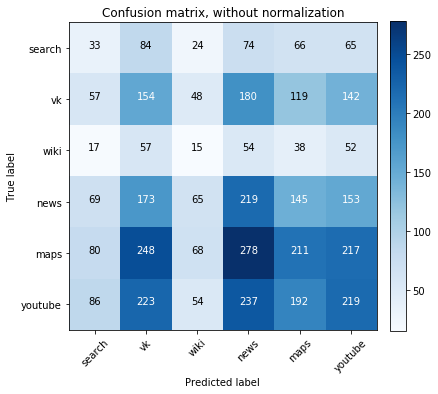

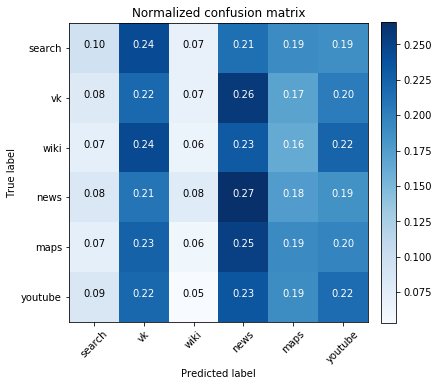

In [8]:
# Confusion Matrix
target_names = ['search', 'vk', 'wiki', 'news', 'maps', 'youtube']
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

p = plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
p = plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Visualize filters

In [9]:
# model layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict.keys()

dict_keys(['pool2', 'pool3', 'pool1', 'flatten1', 'conv1', 'conv3', 'fc1', 'dropout1', 'conv2', 'fc2'])

## Get activations

In [56]:
from keras_helpers import *

In [79]:
def plot_conv1_filter(model, fn, layer='conv1', clip=False):
    """Plot filter representation based on filter weights"""
    W = [l.get_weights()[0] for l in model.layers if l.name == layer][0]
    W = np.squeeze(W)
    W = np.moveaxis(W, 2, 0) 

    # scale weights to [0 1]
    x_min = np.min(W)
    x_max = np.max(W)
    W_norm = (W - x_min) / (x_max - x_min)
    
    filter_weights = W_norm[fn, ...]

    move_dir = denorm(filter_weights[:, 0], x_max=np.pi*2)
    move_len = denorm(filter_weights[:, 1], x_max=1.44)

    xy = traject_to_coord(move_dir, move_len, x_init=0.5, y_init=0.5)
    p = plot_path(xy, screen_lims=False, show_joints=True, clip=clip)
    return p

In [69]:
# Generate data to test filter activation
test_images = []

for i in range(1, 4):

    directions = np.repeat(np.pi/i, TIMESTEPS)
    dir_norm = norm_values(directions, 0, 2 * np.pi)

    lenghts = np.repeat(1/TIMESTEPS, TIMESTEPS)
    len_norm = norm_values(lenghts, 0, 1.44)
    im = np.vstack([dir_norm, len_norm]).T # (37944, 1, 30, 2)
    im = np.expand_dims(im, 0)
    im = np.expand_dims(im, 0)
    test_images.append(im)

test_images = np.vstack(test_images)
print(test_images.shape)

(3, 1, 30, 2)


conv1 (4216, 1, 30, 32)


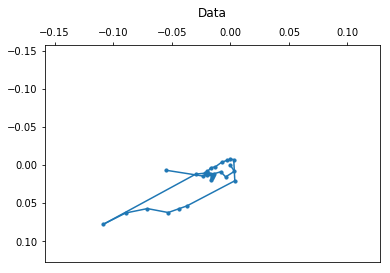

FILTER # 0


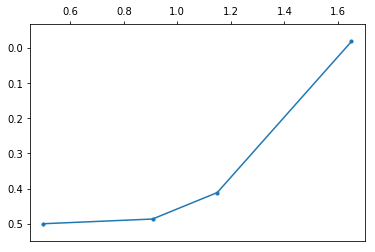

filter activations 0


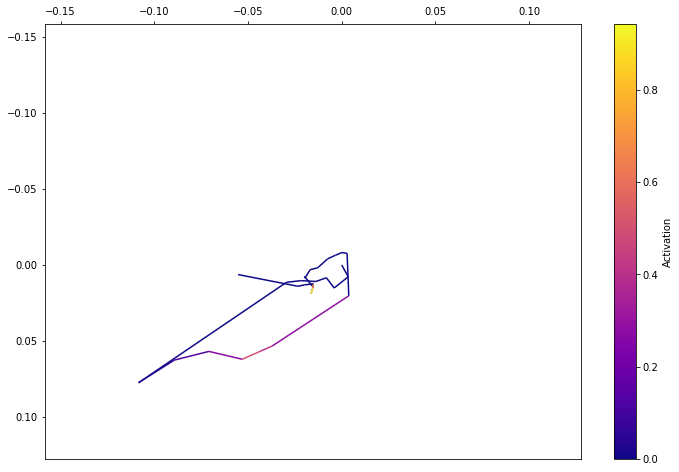

FILTER # 1


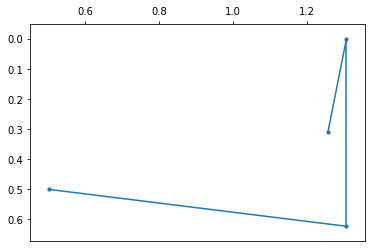

filter activations 1


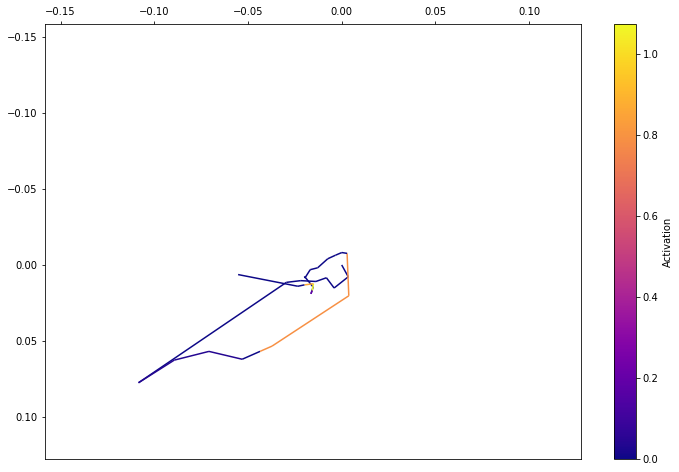

FILTER # 2


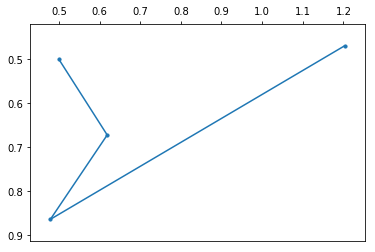

filter activations 2


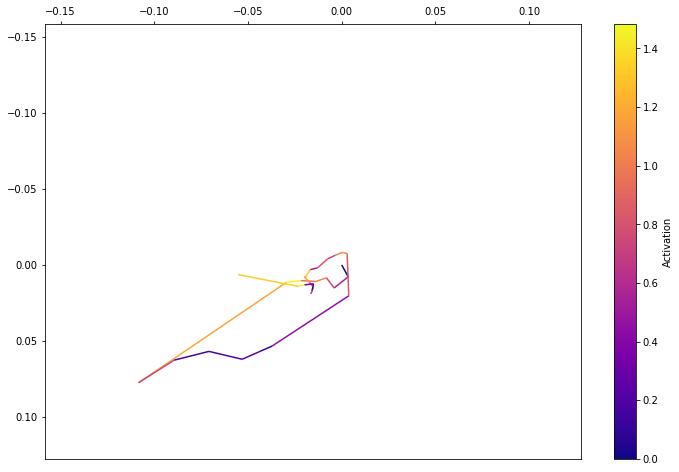

FILTER # 3


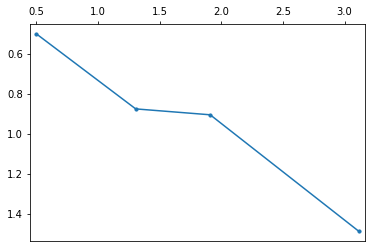

filter activations 3


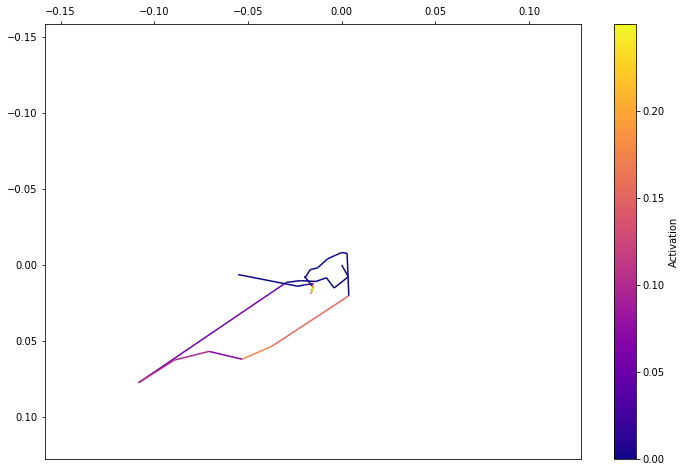

FILTER # 4


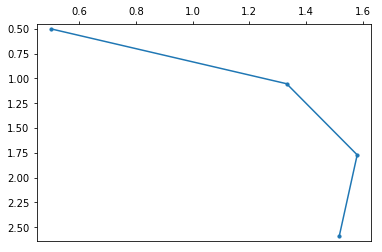

filter activations 4


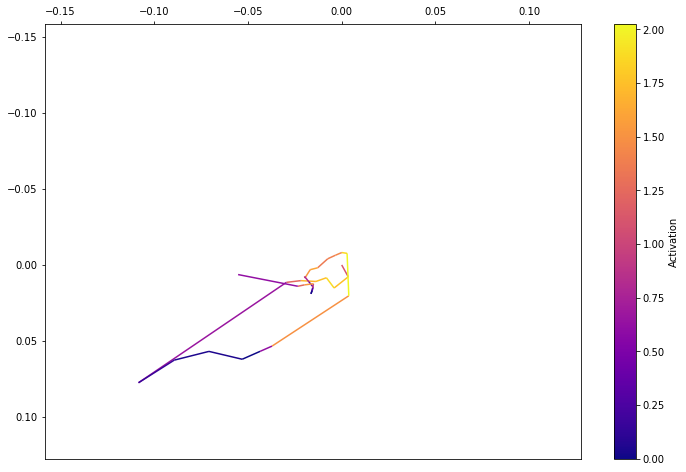

FILTER # 5


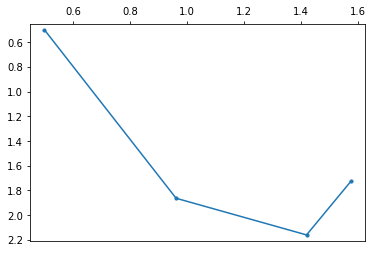

filter activations 5


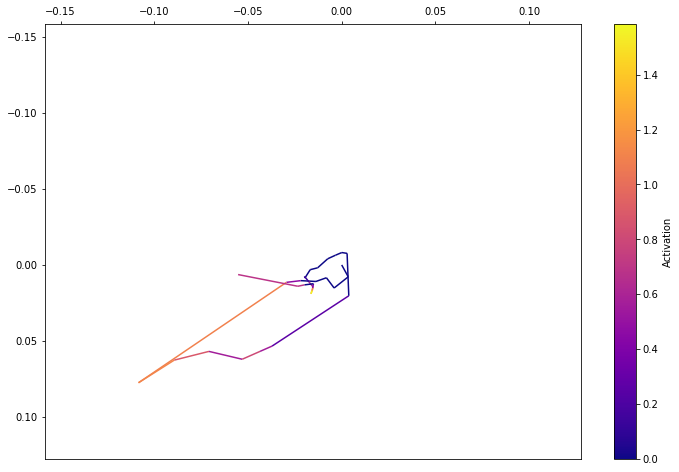

FILTER # 6


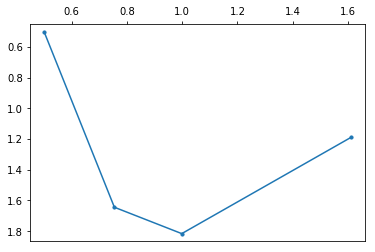

filter activations 6


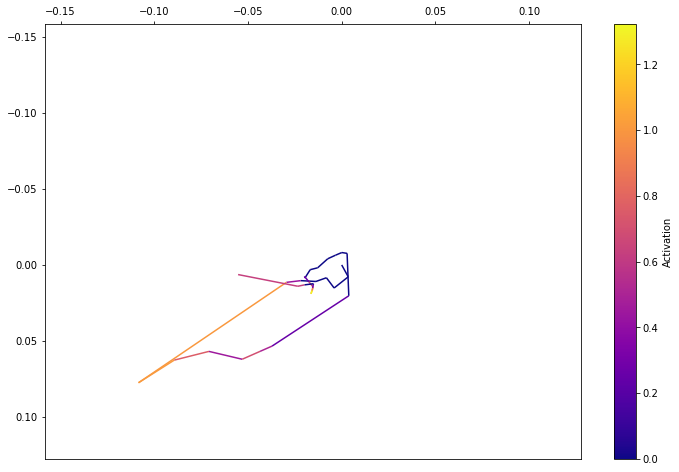

FILTER # 7


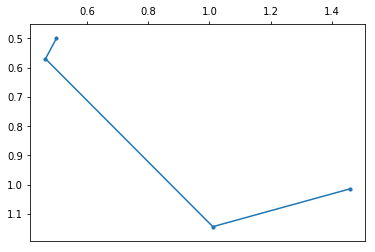

filter activations 7


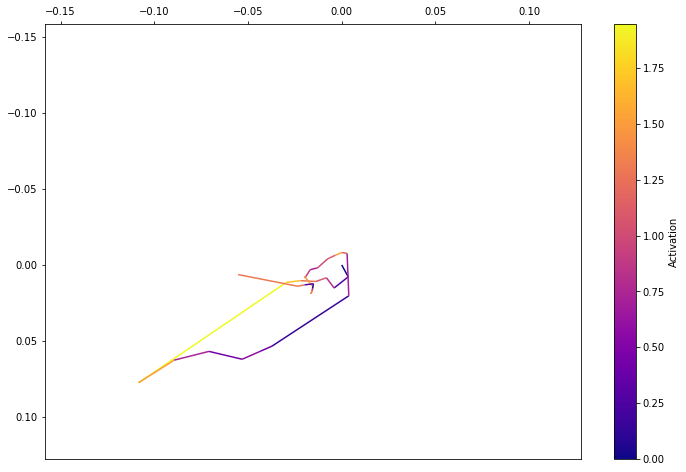

FILTER # 8


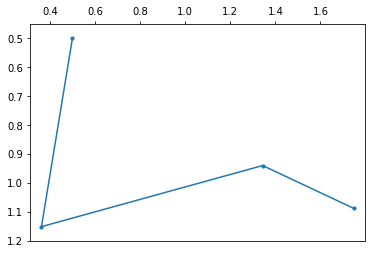

filter activations 8


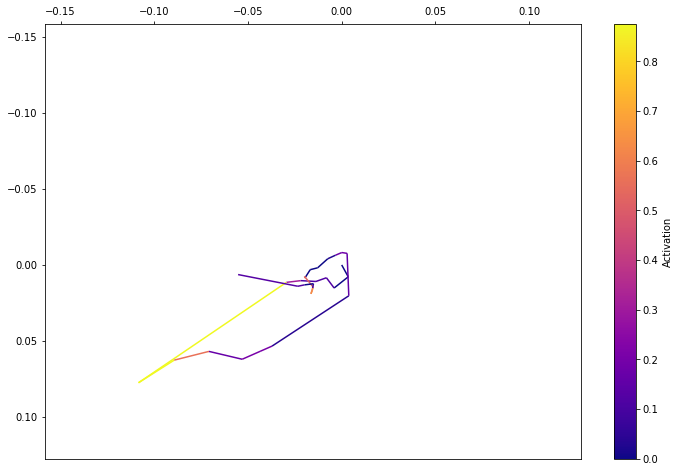

FILTER # 9


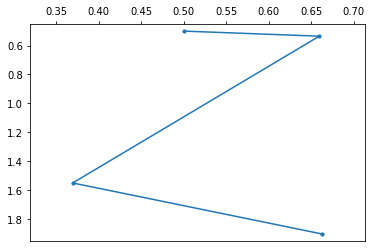

filter activations 9


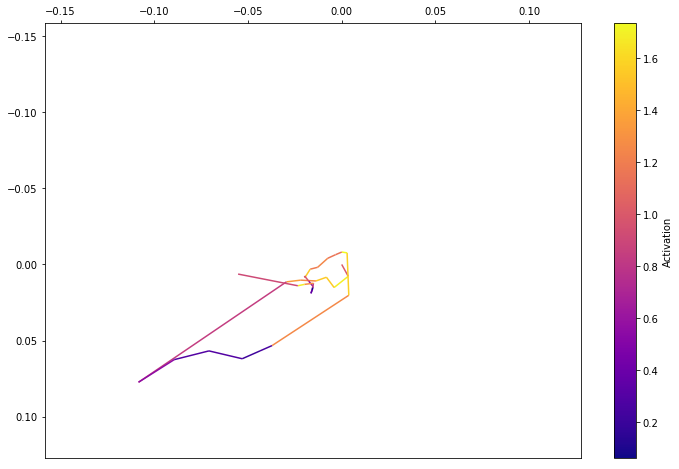

In [78]:
# Visualize filters and their activations on the input sequence
l = 'conv1'
num_obs = 1
shift = 0
num_filters = 10 #activations[l].shape[-1]
data = x_test #test_images

activations = get_activations(model, data, layers=[l])
for k, v in activations.items():
    print(k, v.shape)
    
lines = []
for i in range(num_obs):
    path = data[shift+i, 0, ...]
    move_dir = denorm(path[:, 0], x_max=np.pi*2)
    move_len = denorm(path[:, 1], x_max=1.44)
    xy = traject_to_coord(move_dir, move_len)
    segments = list(zip(xy[:-1], xy[1:]))
    lines.append(segments)

lines = np.concatenate(lines)
p = plot_path(lines, feed_lines=True, screen_lims=False, title='Data', show_joints=True, clip=False)
plt.show()

for f in range(num_filters):
    print("filter #".upper(), f)
    p = plot_conv1_filter(model, f, clip=False)
    plt.show()
    print("filter activations", f)
    
    fw = np.concatenate([activations[l].squeeze()[i, :, f] for i in range(num_obs)])
    if not np.all(fw == 0):
        fw = filter_act_to_input(fw, model, l, len(fw))
        
    p = plot_path(lines, segments_weights=fw, figsize=(12, 8), change_width=False, clip=False, feed_lines=True)
    plt.show()

In [21]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in np.arange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


W shape :  (32, 2, 3)


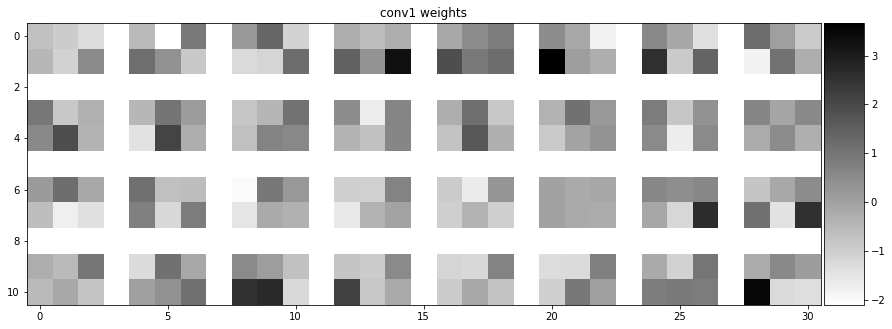

In [22]:
# Visualize weights
W = model.layers[0].get_weights()[0]
W = np.squeeze(W).swapaxes(0, 2)
print("W shape : ", W.shape)


plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W, 4, 8), cmap=plt.cm.binary)